# SSP projections

Pretty much a direct copy of the `fair calibrate` SSP code from https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/AR6-updated_no-contrails/constraining/05_constrained-ssp-projections.py.

All external files used here can be found in the `fair-calibrate-1.4.0` zipfile at https://zenodo.org/records/10566646.

From Katsu: 
Since full data can be a lot of data, could you share selected percentiles first? I think that the atmospheric CO2, CH4, and N2O concentrations, total aerosol forcing (both direct and indirect effects), total forcing, and global-mean temperatures are the most important. 

In [1]:
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch
import xarray as xr

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

/tmp/ipykernel_80481/269344696.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pl.style.use("../defaults.mplstyle")

In [3]:
os.makedirs("../plots", exist_ok=True)
os.makedirs("../output", exist_ok=True)

In [4]:
scenarios = [
    "ssp119",
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp434",
    "ssp460",
    "ssp534-over",
    "ssp585",
]

In [5]:
df_solar = pd.read_csv(
    "../data/forcing/solar_erf_timebounds.csv", index_col="year"
)
df_volcanic = pd.read_csv(
    "../data/forcing/volcanic_ERF_1750-2101_timebounds.csv",
    index_col="timebounds",
)

In [6]:
solar_forcing = np.zeros(551)
volcanic_forcing = np.zeros(551)
volcanic_forcing[:352] = df_volcanic["erf"].loc[1750:2101].values
solar_forcing = df_solar["erf"].loc[1750:2300].values

In [7]:
ch4_lifetime_file = pooch.retrieve(
    url="https://zenodo.org/records/10566646/files/CH4_lifetime.csv",
    known_hash="5dc09d8cbaebc8d8b3481d29ac6d3c3c6fb0f29be16c8932b540b99c50f4456e"
)

In [8]:
configs_file = pooch.retrieve(
    url="https://zenodo.org/records/10566646/files/calibrated_constrained_parameters.csv",
    known_hash="a6451eede608ca149cc9a8a9a75c5ef4e4a119e0e60422f65823e5781f0a1c32"
)

In [9]:
df_methane = pd.read_csv(ch4_lifetime_file, index_col=0)
df_configs = pd.read_csv(configs_file, index_col=0)
valid_all = df_configs.index

In [10]:
trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)
f.define_scenarios(scenarios)
f.define_configs(valid_all)
species, properties = read_properties()
species.remove("Halon-1202")
species.remove("NOx aviation")
species.remove("Contrails")
f.define_species(species, properties)
f.allocate()

In [11]:
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500.nc")

In [12]:
da = da_emissions.loc[dict(config="unspecified")][:550, ...]
fe = da.expand_dims(dim=["config"], axis=(2))
f.emissions = fe.drop_vars("config") * np.ones((1, 1, 841, 1))

In [13]:
# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(
    f.climate_configs["ocean_heat_capacity"],
    df_configs.loc[:, "clim_c1":"clim_c3"].values,
)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)  # not massively robust, since relies on kappa1, kappa2, kappa3 being in adjacent cols
fill(
    f.climate_configs["deep_ocean_efficacy"],
    df_configs["clim_epsilon"].values.squeeze(),
)
fill(
    f.climate_configs["gamma_autocorrelation"],
    df_configs["clim_gamma"].values.squeeze(),
)
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_airborne"],
    df_configs["cc_rA"].values.squeeze(),
    specie="CO2",
)
fill(
    f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2"
)
fill(
    f.species_configs["iirf_temperature"],
    df_configs["cc_rT"].values.squeeze(),
    specie="CO2",
)

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(
    f.species_configs["aci_shape"],
    df_configs["aci_shape_so2"].values.squeeze(),
    specie="Sulfur",
)
fill(
    f.species_configs["aci_shape"],
    df_configs["aci_shape_bc"].values.squeeze(),
    specie="BC",
)
fill(
    f.species_configs["aci_shape"],
    df_configs["aci_shape_oc"].values.squeeze(),
    specie="OC",
)

# methane lifetime baseline and sensitivity
fill(
    f.species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f.species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# emissions adjustments for N2O and CH4
fill(f.species_configs["baseline_emissions"], 19.019783117809567, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.08602230754, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.423526730206152, specie="NOx")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs[f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs[f"fscale_{specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs["fscale_minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs[f"o3_{specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs["cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

# initial conditions
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

In [14]:
f.run()

Running 6728 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

In [15]:
fancy_titles = {
    "ssp119": "SSP1-1.9",
    "ssp126": "SSP1-2.6",
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp434": "SSP4-3.4",
    "ssp460": "SSP4-6.0",
    "ssp534-over": "SSP5-3.4-overshoot",
    "ssp585": "SSP5-8.5",
}

ar6_colors = {
    "ssp119": "#00a9cf",
    "ssp126": "#003466",
    "ssp245": "#f69320",
    "ssp370": "#df0000",
    "ssp434": "#2274ae",
    "ssp460": "#b0724e",
    "ssp534-over": "#92397a",
    "ssp585": "#980002",
}

In [16]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [17]:
df_gmst = pd.read_csv("../data/obs/IGCC_GMST_1850-2022.csv")
gmst = df_gmst["gmst"].values

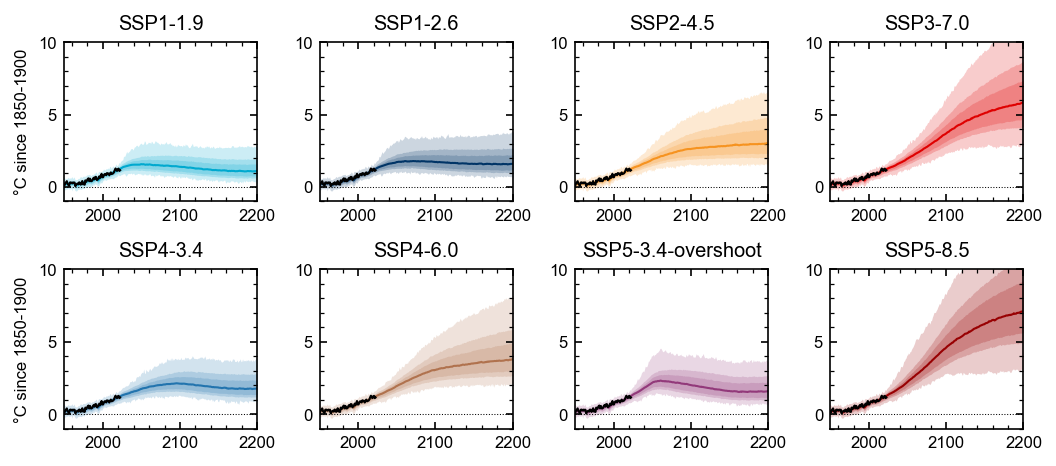

In [18]:
fig, ax = pl.subplots(2, 4, figsize=(18 / 2.54, 8 / 2.54))
for i in range(8):
    ax[i // 4, i % 4].fill_between(
        np.arange(1750, 2301),
        np.min(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            axis=1,
        ),
        np.max(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        alpha=0.2,
        lw=0,
    )
    ax[i // 4, i % 4].fill_between(
        np.arange(1750.5, 2301),
        np.percentile(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            5,
            axis=1,
        ),
        np.percentile(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            95,
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        alpha=0.2,
        lw=0,
    )
    ax[i // 4, i % 4].fill_between(
        np.arange(1750.5, 2301),
        np.percentile(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            16,
            axis=1,
        ),
        np.percentile(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            84,
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        alpha=0.2,
        lw=0,
    )
    ax[i // 4, i % 4].plot(
        np.arange(1750.5, 2301),
        np.median(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
    )
    ax[i // 4, i % 4].plot(np.arange(1850.5, 2023), gmst, color="k", lw=1)
    ax[i // 4, i % 4].set_xlim(1950, 2200)
    ax[i // 4, i % 4].set_ylim(-1, 10)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

ax[0, 0].set_ylabel("°C since 1850-1900")
ax[1, 0].set_ylabel("°C since 1850-1900")

fig.tight_layout()
pl.savefig("../plots/ssp_temperatures_uncertainties.png")

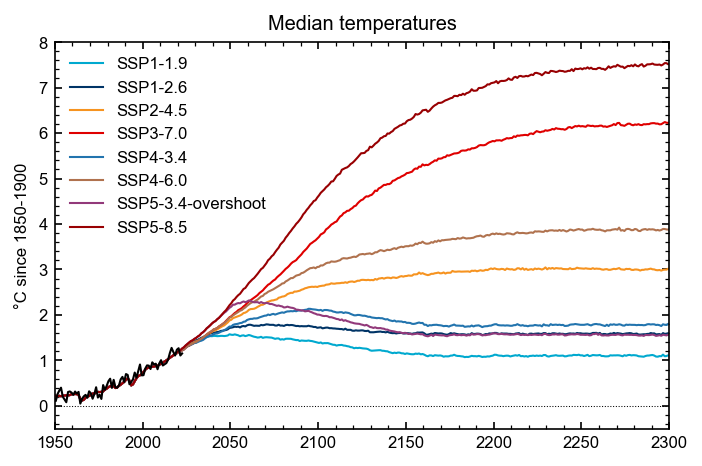

In [19]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.temperature[:, i, :, 0]
            - np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.plot(np.arange(1850.5, 2023), gmst, color="k", lw=1)
ax.set_xlim(1950, 2300)
ax.set_ylim(-0.5, 8)
ax.axhline(0, color="k", ls=":", lw=0.5)
    # ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

ax.legend(frameon=False)
ax.set_ylabel("°C since 1850-1900")
ax.set_title('Median temperatures')

fig.tight_layout()
pl.savefig("../plots/ssp_temperatures_median.png")

In [20]:
df_conc = pd.read_csv("../data/obs/ghg_concentrations_1750-2022.csv")
df_conc["CO2"]
df_conc["YYYY"]

0      1750
1      1850
2      1851
3      1852
4      1853
       ... 
169    2018
170    2019
171    2020
172    2021
173    2022
Name: YYYY, Length: 174, dtype: int64

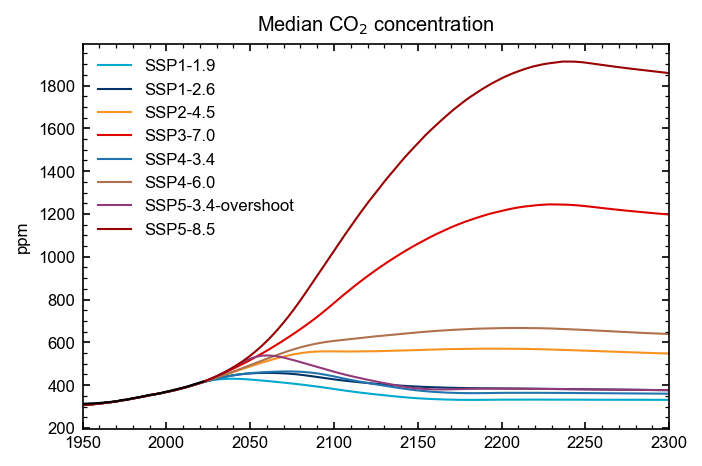

In [21]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.concentration[:, i, :, 2],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.plot(df_conc['YYYY'], df_conc['CO2'], color="k", lw=1)
ax.set_xlim(1950, 2300)
#ax.set_ylim(-0.5, 8)
    # ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

ax.legend(frameon=False)
ax.set_ylabel("ppm")
ax.set_title('Median CO$_2$ concentration')

fig.tight_layout()
pl.savefig("../plots/ssp_co2_concentration_median.png")

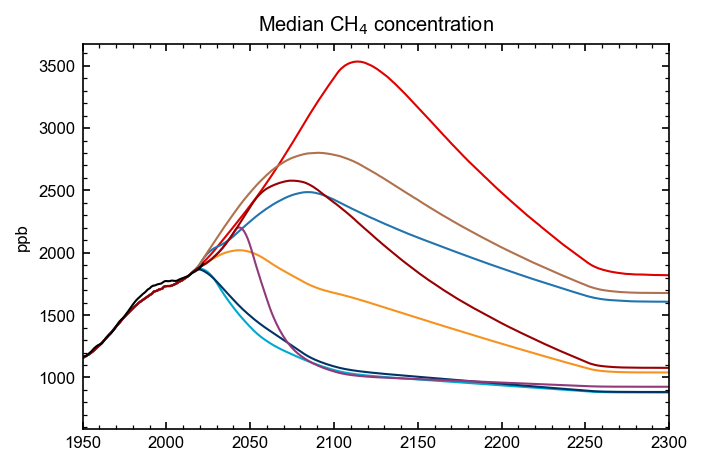

In [22]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.concentration[:, i, :, 3],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.plot(df_conc['YYYY'], df_conc['CH4'], color="k", lw=1)
ax.set_xlim(1950, 2300)
#ax.set_ylim(-0.5, 8)
    # ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

#ax.legend(frameon=False)
ax.set_ylabel("ppb")
ax.set_title('Median CH$_4$ concentration')

fig.tight_layout()
pl.savefig("../plots/ssp_ch4_concentration_median.png")

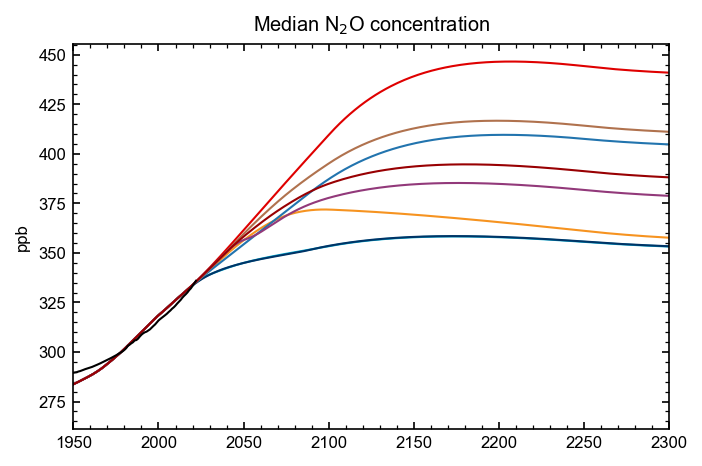

In [23]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.concentration[:, i, :, 4],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.plot(df_conc['YYYY'], df_conc['N2O'], color="k", lw=1)
ax.set_xlim(1950, 2300)
#ax.set_ylim(-0.5, 8)
    # ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

#ax.legend(frameon=False)
ax.set_ylabel("ppb")
ax.set_title('Median N$_2$O concentration')

fig.tight_layout()
pl.savefig("../plots/ssp_n2o_concentration_median.png")

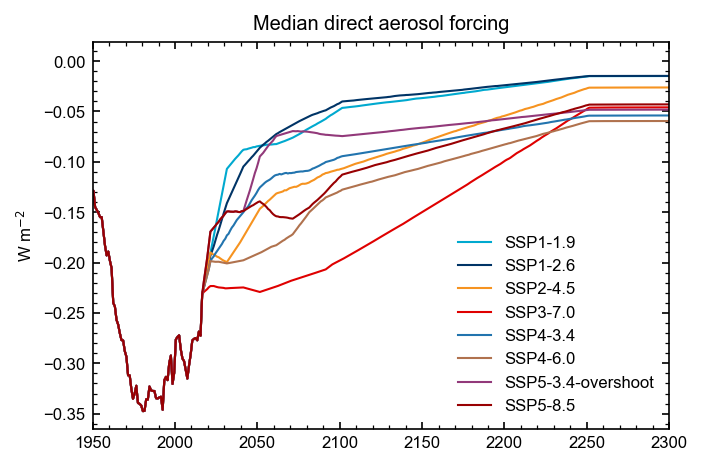

In [24]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.forcing[:, i, :, 54],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.set_xlim(1950, 2300)
#ax.set_ylim(-0.5, 8)
    # ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

ax.legend(frameon=False)
ax.set_ylabel("W m$^{-2}$")
ax.set_title('Median direct aerosol forcing')

fig.tight_layout()
pl.savefig("../plots/ssp_direct_aerosol_forcing_median.png")

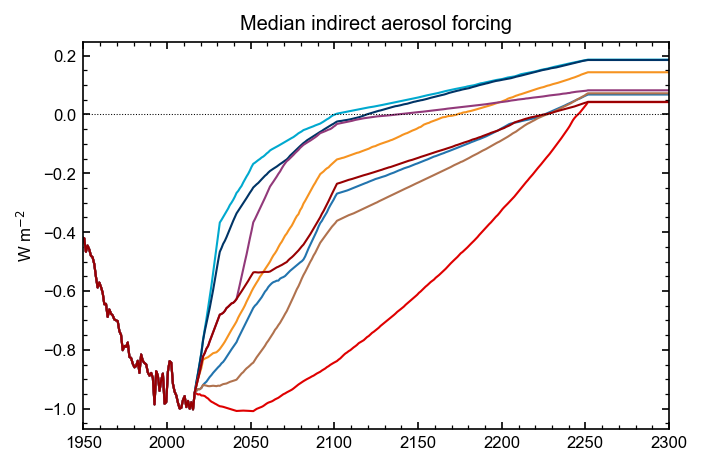

In [25]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.forcing[:, i, :, 55],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.set_xlim(1950, 2300)

# ax.legend(frameon=False)
ax.set_ylabel("W m$^{-2}$")
ax.set_title('Median indirect aerosol forcing')
ax.axhline(0, color="k", ls=":", lw=0.5)

fig.tight_layout()
pl.savefig("../plots/ssp_indirect_aerosol_forcing_median.png")

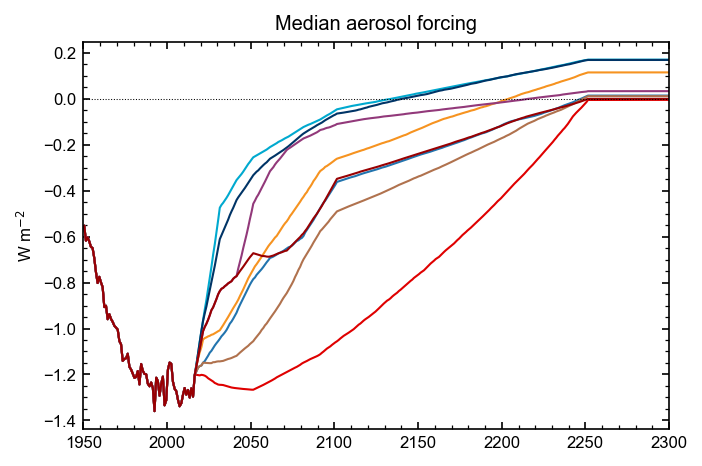

In [26]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.forcing[:, i, :, 54:56].sum(axis=-1),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.set_xlim(1950, 2300)

# ax.legend(frameon=False)
ax.set_ylabel("W m$^{-2}$")
ax.set_title('Median aerosol forcing')
ax.axhline(0, color="k", ls=":", lw=0.5)

fig.tight_layout()
pl.savefig("../plots/ssp_total_aerosol_forcing_median.png")

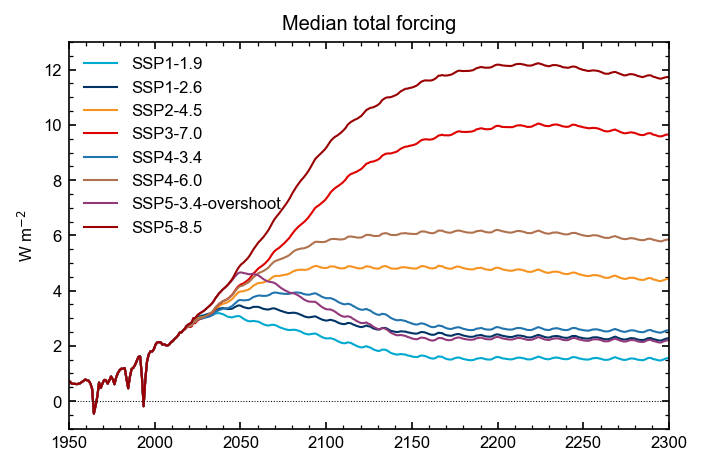

In [27]:
fig, ax = pl.subplots(figsize=(12 / 2.54, 8 / 2.54))
for i in range(8):
    ax.plot(
        np.arange(1750.5, 2301),
        np.median(
            f.forcing_sum[:, i, :],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
        lw=1,
        label = fancy_titles[scenarios[i]]
    )
ax.set_xlim(1950, 2300)
ax.set_ylim(-1, 13)

ax.axhline(0, color="k", ls=":", lw=0.5)

ax.legend(frameon=False)
ax.set_ylabel("W m$^{-2}$")
ax.set_title('Median total forcing')

fig.tight_layout()
pl.savefig("../plots/ssp_total_forcing_median.png")

In [28]:
# Gather into one dataset
for i in range(8):
    baseline = np.average(f.temperature[100:152, i, :, 0], axis=0, weights=weights_51yr)
    t0 = np.min(f.temperature[:, i, :, 0] - baseline, axis=1)
    t5 = np.percentile(f.temperature[:, i, :, 0] - baseline, 5, axis=1)
    t16 = np.percentile(f.temperature[:, i, :, 0] - baseline, 16, axis=1)
    t50 = np.percentile(f.temperature[:, i, :, 0] - baseline, 50, axis=1)
    t84 = np.percentile(f.temperature[:, i, :, 0] - baseline, 84, axis=1)
    t95 = np.percentile(f.temperature[:, i, :, 0] - baseline, 95, axis=1)
    t100 = np.min(f.temperature[:, i, :, 0] - baseline, axis=1)
    cco2 = np.median(f.concentration[:, i, :, 2], axis=1)
    cch4 = np.median(f.concentration[:, i, :, 3], axis=1)
    cn2o = np.median(f.concentration[:, i, :, 4], axis=1)
    faerd = np.median(f.forcing[:, i, :, 54], axis=1)
    faeri = np.median(f.forcing[:, i, :, 55], axis=1)
    faer = np.median(f.forcing[:, i, :, 54] + f.forcing[:, i, :, 55], axis=1)
    ftot = np.median(f.forcing_sum[:, i, :], axis=1)

    df_out = pd.DataFrame(
        {
            't0': t0,
            't5': t5,
            't16': t16,
            't50': t50,
            't84': t84,
            't95': t95,
            't100': t100,
            'cco2_50': cco2,
            'cch4_50': cch4,
            'cn2o': cn2o,
            'faerd_50': faerd,
            'faeri_50': faeri,
            'faer_50': faer,
            'ftot_50': ftot
        },
        index=np.arange(1750, 2301)
    )
    df_out.to_csv(f'../output/{scenarios[i]}.csv')